In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install monai torch pydicom matplotlib nibabel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 43.2 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import torch
import pydicom
import matplotlib.pyplot as plt

from monai.bundle import ConfigParser, download
from monai.transforms import LoadImage, LoadImaged, Orientation, Orientationd, EnsureChannelFirst, EnsureChannelFirstd, Compose

from scipy.ndimage import label, measurements
from pydicom.dataset import FileDataset
import json


Copy 15944994557 –  15944994678  files to Axial folder. Run one time.



In [ ]:
import os
import shutil

# Define the source and destination directories
source_dir = "/content/drive/My Drive/Aortic/CT/CT/2"
destination_dir = "/content/drive/My Drive/Aortic/Axial"

# Ensure the destination directory exists, create it if not
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Loop through the range of DICOM files (from 15944994557 to 15944994677)
for i in range(15944994557, 15944994678):
    dicom_filename = f"{i}.dcm"  # Assuming DICOM files have .dcm extension
    source_file = os.path.join(source_dir, dicom_filename)

    # Check if the file exists in the source directory
    if os.path.exists(source_file):
        destination_file = os.path.join(destination_dir, dicom_filename)

        # Copy the file to the destination directory
        shutil.copy(source_file, destination_file)
        print(f"Copied {dicom_filename} to {destination_dir}")
    else:
        print(f"File {dicom_filename} not found in {source_dir}")

In [4]:
# Load configuration paths
image_directory = '/content/drive/My Drive/Aortic/Axial'
config_file_path = '/content/drive/My Drive/Aortic/configs_inference.json'
trained_model_path = "/content/drive/My Drive/Aortic/model_lowres.pt"

# Initialize config parser and load configuration
config_parser = ConfigParser()
config_parser.read_config(config_file_path)

# Extract preprocessing and postprocessing pipelines from the config
postprocessing_pipeline = config_parser.get_parsed_content("postprocessing")
preprocessing_pipeline = config_parser.get_parsed_content("preprocessing")

# Load image using preprocessing pipeline
input_data = preprocessing_pipeline({'image': image_directory})
print(f"Loaded image shape: {input_data['image'].shape}")

Loaded image shape: torch.Size([1, 121, 121, 101])


In [5]:
# Load the model architecture from config and load trained weights
model_architecture = config_parser.get_parsed_content("network")
model_architecture.load_state_dict(torch.load(trained_model_path, map_location=torch.device('cpu')))
model_architecture.eval()

# Initialize the inference engine (inferer) from config
inference_engine = config_parser.get_parsed_content("inferer")

# Perform inference
with torch.no_grad():
    input_data['pred'] = inference_engine(input_data['image'].unsqueeze(0), network=model_architecture)


<ipython-input-5-b625b4750525>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_architecture.load_state_dict(torch.load(trained_model_path, map_location=torch.device('

In [6]:
# Remove batch dimension
input_data['pred'] = input_data['pred'][0]
input_data['image'] = input_data['image'][0]

# Apply postprocessing steps to predictions
processed_data = postprocessing_pipeline(input_data)

# Flip the prediction along the z-axis to match original orientation
segmentation_result = torch.flip(processed_data['pred'][0], dims=[2])

# Convert to numpy array for visualization and analysis
segmentation_result = segmentation_result.cpu().numpy()

print(segmentation_result.shape)
print(input_data['image'].shape)

2025-01-24 20:02:23,976 INFO image_writer.py:197 - writing: eval/Axial/Axial_trans.nii.gz
(512, 512, 121)
torch.Size([121, 121, 101])


In [7]:
image_loader = LoadImage(image_only=True)
CT_image = image_loader(image_directory)

# Ensure image has a channel dimension as the first axis (1, Z, H, W)
channel_transformer = EnsureChannelFirst()
CT_image = channel_transformer(CT_image)

# Reorient the image to match desired coordinate system (LPS)
orientation_transformer = Orientation(axcodes=('LPS'))
CT_image = orientation_transformer(CT_image)

# Visualize coronal slices of the CT and segmentation result


In [ ]:
# Load CT images from directory


# Visualize coronal slices of the CT and segmentation result
for slice_index in range(CT_image.shape[2]):
    # Extract the coronal slice for the given index
    CT_coronal_slice = CT_image[0, :, slice_index].cpu().numpy()
    segmentation_coronal_slice = segmentation_result[:, slice_index]

    # Display the CT slice and segmentation mask side by side
    plt.subplots(1, 2, figsize=(7, 7))

    # Plot CT slice
    plt.subplot(121)
    plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
    plt.axis('off')

    # Plot segmentation slice
    plt.subplot(122)
    plt.pcolormesh(segmentation_coronal_slice.T, cmap='nipy_spectral')
    plt.axis('off')

    plt.show()




Aortic Volume: 227.5 cm^3


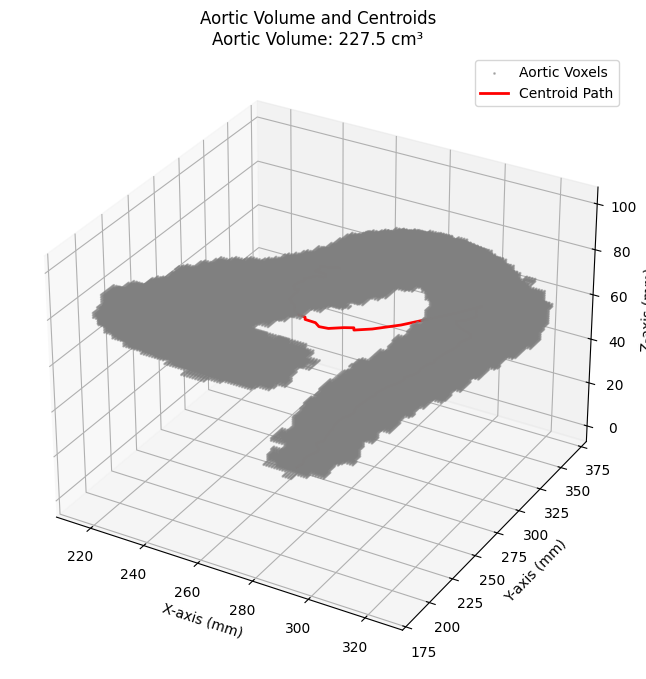

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Calculate Aortic Volume
aortic_voxel_count = (segmentation_result == 7).sum().item()  # Label 7 corresponds to aorta
voxel_volume_cm3 = np.prod(CT_image.meta['spacing'] / 10)  # Convert voxel spacing from mm to cm
aortic_volume_cm3 = aortic_voxel_count * voxel_volume_cm3
print(f'Aortic Volume: {aortic_volume_cm3:.1f} cm^3')

# Extract Aortic Voxel Coordinates
aorta_voxels_mask = segmentation_result == 7
aorta_voxel_coordinates = np.argwhere(aorta_voxels_mask)

# Calculate Centroids
z_slices = np.unique(aorta_voxel_coordinates[:, 2])  # Assuming [x, y, z] format
centroids = []
for z in z_slices:
    slice_voxels = aorta_voxel_coordinates[aorta_voxel_coordinates[:, 2] == z]
    if len(slice_voxels) > 0:
        centroid = np.mean(slice_voxels[:, :2], axis=0)  # Compute centroid in (x, y)
        centroids.append((z, *centroid))
centroids_array = np.array(centroids)
z = centroids_array[:, 0]  # Z-coordinates
x = centroids_array[:, 1]  # X-centroid
y = centroids_array[:, 2]  # Y-centroid

# Plot 3D Aortic Volume and Centroids
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot Aortic Voxels
ax.scatter(aorta_voxel_coordinates[:, 0],
           aorta_voxel_coordinates[:, 1],
           aorta_voxel_coordinates[:, 2],
           c='grey', alpha=0.5, s=1, label="Aortic Voxels")

# Plot Centroids
ax.plot(x, y, z, color='red', linewidth=2, label="Centroid Path")

# Customize Plot
ax.set_xlabel("X-axis (mm)")
ax.set_ylabel("Y-axis (mm)")
ax.set_zlabel("Z-axis (mm)")
ax.set_title(f"Aortic Volume and Centroids\nAortic Volume: {aortic_volume_cm3:.1f} cm³")
ax.legend()

plt.show()


# Calculate the aortic volume from segmentation


In [ ]:

aortic_voxel_count = (segmentation_result == 7).sum().item()  # Label 7 corresponds to aorta in segmentation
voxel_volume_cm3 = np.prod(CT_image.meta['spacing'] / 10)  # Convert voxel spacing from mm to cm
aortic_volume_cm3 = aortic_voxel_count * voxel_volume_cm3
print(f'Aortic Volume: {aortic_volume_cm3:.1f} cm^3')

# Extract the coordinates of the aortic voxels
aorta_voxels_mask = segmentation_result == 7
aorta_voxel_coordinates = np.argwhere(aorta_voxels_mask)

# Save the aorta voxel coordinates to a CSV file
np.savetxt("aorta_coordinates.csv", aorta_voxel_coordinates, delimiter=",", fmt="%d")

Aortic Volume: 227.5 cm^3




### **Milestone2**

In [ ]:
z_slices = np.unique(aorta_voxel_coordinates[:, 2])  # Assuming [x, y, z] format
centroids = []

for z in z_slices:
    slice_voxels = aorta_voxel_coordinates[aorta_voxel_coordinates[:, 2] == z]
    if len(slice_voxels) > 0:
        centroid = np.mean(slice_voxels[:, :2], axis=0)  # Compute centroid in (x, y)
        centroids.append((z, *centroid))  # Store as (z, x_centroid, y_centroid)

# Convert centroids to NumPy array
centroids_array = np.array(centroids)
z = centroids_array[:, 0]  # Z-coordinates
x = centroids_array[:, 1]  # X-coordinates
y = centroids_array[:, 2]  # Y-coordinates


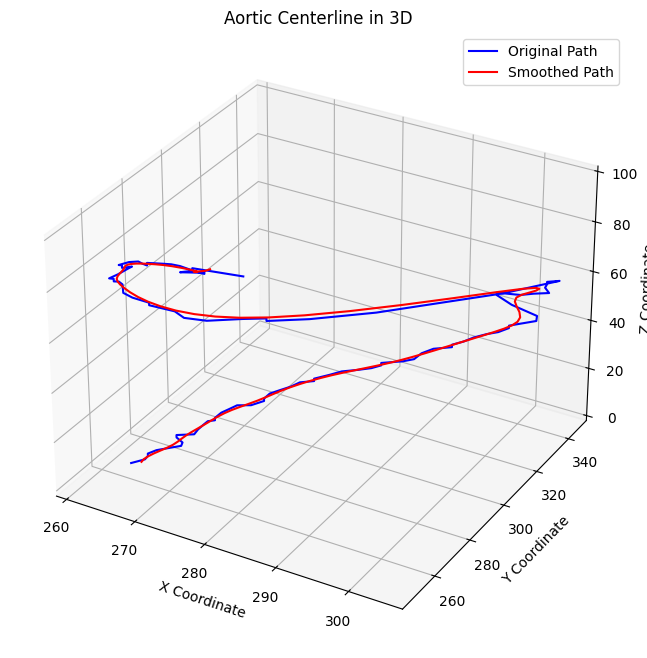

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Smoothing the data to remove noise
smoothed_x = gaussian_filter1d(x, sigma=2)
smoothed_y = gaussian_filter1d(y, sigma=2)

# Plotting the aortic centerline in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot original centroids
ax.plot(x, y, z, label='Original Path', color='blue')
# Plot smoothed centroids
ax.plot(smoothed_x, smoothed_y, z, label='Smoothed Path', color='red')

# Add labels and title
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title('Aortic Centerline in 3D')
ax.legend()

The plane is fixed, meaning it does not rotate or tilt.
The cross-sectional surface area is calculated by intersecting the object with this fixed plane at a given ZZ-coordinate.
This method assumes that the smallest cross-section is always aligned with the global coordinate axes.

In [ ]:
import numpy as np
from scipy.spatial import ConvexHull
from scipy.spatial.distance import pdist

# Function to calculate area and diameters
def calculate_slice_metrics(slice_voxels):
    if len(slice_voxels) < 3:
        return 0, 0, 0  # Not enough points to form a valid convex hull

    hull = ConvexHull(slice_voxels)
    area = hull.volume  # Convex hull area
    distances = pdist(slice_voxels)  # Pairwise distances between points
    max_diameter = np.max(distances)
    min_diameter = np.min(distances)
    return area, max_diameter, min_diameter

# Centroids computation function (ensure (z, x, y) structure)
def compute_centroids(aorta_voxel_coordinates, z_slices):
    centroids = []
    for z in z_slices:
        slice_voxels = aorta_voxel_coordinates[aorta_voxel_coordinates[:, 2] == z]
        if len(slice_voxels) > 0:
            centroid = np.mean(slice_voxels[:, :2], axis=0)  # Compute centroid in (x, y)
            centroids.append((z, *centroid))  # Store as (z, x_centroid, y_centroid)
    return centroids



# Calculate centroids
centroids = compute_centroids(aorta_voxel_coordinates, z_slices)

# Initialize results
aortic_metrics = []
for z in z_slices:
    slice_voxels = aorta_voxel_coordinates[aorta_voxel_coordinates[:, 2] == z][:, :2]  # Extract (x, y) coordinates
    area, max_diameter, min_diameter = calculate_slice_metrics(slice_voxels)
    aortic_metrics.append((z, area, max_diameter, min_diameter))

# Find the plane with minimal cross-sectional area
min_area_plane = min(aortic_metrics, key=lambda x: x[1])  # Find the minimum area
min_z, min_area, _, _ = min_area_plane

# Compute inclination angles based on centroid movement
centroids_array = np.array(centroids)  # Ensure centroids array has (z, x, y) format
diff = np.diff(centroids_array, axis=0)  # Differences in (z, x, y)
angles = np.arctan2(np.linalg.norm(diff[:, 1:], axis=1), diff[:, 0])  # Inclination angles in radians
avg_angle_degrees = np.degrees(np.mean(angles))  # Convert average inclination to degrees

# Output the results
print("Aortic Dimensions by Z-Slice:")
for z, area, max_d, min_d in aortic_metrics:
    print(f"Z={z}, Area={area:.2f} cm², Max Diameter={max_d:.2f} cm, Min Diameter={min_d:.2f} cm")

print(f"\nPlane with Minimal Cross-Sectional Area: Z={min_z}, Area={min_area:.2f} cm²")
print(f"Average Inclination Angle of Aorta: {avg_angle_degrees:.2f}°")

Aortic Dimensions by Z-Slice:
Z=0, Area=353.00 cm², Max Diameter=23.71 cm, Min Diameter=1.00 cm
Z=1, Area=349.50 cm², Max Diameter=24.19 cm, Min Diameter=1.00 cm
Z=2, Area=377.50 cm², Max Diameter=26.40 cm, Min Diameter=1.00 cm
Z=3, Area=377.50 cm², Max Diameter=26.40 cm, Min Diameter=1.00 cm
Z=4, Area=397.50 cm², Max Diameter=25.00 cm, Min Diameter=1.00 cm
Z=5, Area=376.00 cm², Max Diameter=25.61 cm, Min Diameter=1.00 cm
Z=6, Area=486.00 cm², Max Diameter=28.28 cm, Min Diameter=1.00 cm
Z=7, Area=563.50 cm², Max Diameter=30.08 cm, Min Diameter=1.00 cm
Z=8, Area=568.00 cm², Max Diameter=31.38 cm, Min Diameter=1.00 cm
Z=9, Area=568.00 cm², Max Diameter=31.38 cm, Min Diameter=1.00 cm
Z=10, Area=600.00 cm², Max Diameter=31.38 cm, Min Diameter=1.00 cm
Z=11, Area=610.00 cm², Max Diameter=32.02 cm, Min Diameter=1.00 cm
Z=12, Area=630.00 cm², Max Diameter=32.02 cm, Min Diameter=1.00 cm
Z=13, Area=664.00 cm², Max Diameter=33.12 cm, Min Diameter=1.00 cm
Z=14, Area=710.00 cm², Max Diameter=33.12 

Compute the smallest cross-sectional surface area for each ZZ-slice while allowing the plane to tilt in both XX and YY dimensions
The measurement allows the plane to tilt in both the XX- and YY-dimensions.
At each ZZ-coordinate, the plane is adjusted (rotated) around the centroid of the cross-section to minimize the cross-sectional area.
This tilting accounts for non-axis-aligned geometries, where the actual smallest cross-section might not be parallel to the XYXY-plane.
It provides a more accurate measurement of the minimum cross-sectional area for objects that are irregular or tilted.
Output:Optimal tilt angles and minimal cross-sectional areas at each ZZ-slice.

The optimization method used in the "tilted cross-sectional area" code is a grid search over angles to find the smallest cross-sectional area for a plane intersecting the aorta at each ZZ-slice but you can use other methods like Gradient Descent and Evolutionary Algorithms (e.g., Genetic Algorithms)


In [ ]:
import numpy as np
from scipy.spatial import ConvexHull
from scipy.spatial.transform import Rotation as R

# Function to calculate cross-sectional area with tilt
def calculate_tilted_area(slice_voxels, angles):
    if len(slice_voxels) < 3:
        return float('inf')  # Return a very high value for invalid convex hulls

    min_area = float('inf')
    for angle in angles:
        # Create rotation matrix for given angle
        rotation_matrix = R.from_euler('xy', angle, degrees=True).as_matrix()
        rotated_voxels = slice_voxels @ rotation_matrix[:2, :2].T  # Apply rotation to (x, y) coordinates
        hull = ConvexHull(rotated_voxels)
        min_area = min(min_area, hull.volume)  # Update minimum area
    return min_area

# Compute centroids for each Z-slice
def compute_centroids(aorta_voxel_coordinates, z_slices):
    centroids = []
    for z in z_slices:
        slice_voxels = aorta_voxel_coordinates[aorta_voxel_coordinates[:, 2] == z]
        if len(slice_voxels) > 0:
            centroid = np.mean(slice_voxels[:, :2], axis=0)  # Compute centroid in (x, y)
            centroids.append((z, *centroid))  # Store as (z, x_centroid, y_centroid)
    return centroids

# Example input
# Replace `aorta_voxel_coordinates` with actual data
# aorta_voxel_coordinates = np.array([...])
# z_slices = np.unique(aorta_voxel_coordinates[:, 2])

# Tilt angles to test (in degrees)
angles_to_test = [(x_angle, y_angle) for x_angle in range(-10, 11, 5) for y_angle in range(-10, 11, 5)]

# Calculate minimum cross-sectional area for each Z-slice
aortic_metrics = []
for z in z_slices:
    slice_voxels = aorta_voxel_coordinates[aorta_voxel_coordinates[:, 2] == z][:, :2]  # Extract (x, y) coordinates
    min_area = calculate_tilted_area(slice_voxels, angles_to_test)
    aortic_metrics.append((z, min_area))

# Output the results
print("Tilted Cross-Sectional Areas by Z-Slice:")
for z, min_area in aortic_metrics:
    print(f"Z={z}, Min Tilted Area={min_area:.2f} cm²")

Tilted Cross-Sectional Areas by Z-Slice:
Z=0, Min Tilted Area=342.36 cm²
Z=1, Min Tilted Area=338.96 cm²
Z=2, Min Tilted Area=366.12 cm²
Z=3, Min Tilted Area=366.12 cm²
Z=4, Min Tilted Area=385.51 cm²
Z=5, Min Tilted Area=364.66 cm²
Z=6, Min Tilted Area=471.35 cm²
Z=7, Min Tilted Area=546.51 cm²
Z=8, Min Tilted Area=550.87 cm²
Z=9, Min Tilted Area=550.87 cm²
Z=10, Min Tilted Area=581.91 cm²
Z=11, Min Tilted Area=591.61 cm²
Z=12, Min Tilted Area=611.00 cm²
Z=13, Min Tilted Area=643.98 cm²
Z=14, Min Tilted Area=688.59 cm²
Z=15, Min Tilted Area=688.59 cm²
Z=16, Min Tilted Area=783.64 cm²
Z=17, Min Tilted Area=737.08 cm²
Z=18, Min Tilted Area=834.07 cm²
Z=19, Min Tilted Area=908.26 cm²
Z=20, Min Tilted Area=916.02 cm²
Z=21, Min Tilted Area=916.02 cm²
Z=22, Min Tilted Area=868.01 cm²
Z=23, Min Tilted Area=961.12 cm²
Z=24, Min Tilted Area=910.69 cm²
Z=25, Min Tilted Area=883.53 cm²
Z=26, Min Tilted Area=844.74 cm²
Z=27, Min Tilted Area=844.74 cm²
Z=28, Min Tilted Area=986.82 cm²
Z=29, Min Ti